## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Data Preprocessing

In [2]:
df=pd.read_excel("bme_clinical_data.xlsx",sheet_name="BME_Analysis_Data",header=1)
#We need to take only trauma patient data: upto 63 rows and all columns
df=df.iloc[:63,1:] 
#Quantitative Columns
quant_columns=['Age','Lysis at One Hour (%)','Delta OD','Turbidity T to Half Max (s)','T to Half Max (s)','Polym Rate (OD/s)','etoh','Lactate (mmol/L)','ddimer','fibrinogen','bicarb','base',
'Temperature (°C)','Revised Trauma Score','triss','ais','prbc','ffp','platelet','cryo','plt','sat','rr']

for col in quant_columns:
    df[col].fillna(df[col].median(),inplace=True)

#Zero Columns
zero_columns=['airway_type','chesttube','ir','or','or_art','or_ven','Abbreviated Injury Scale Head','ais_face','ais_neck','ais_chest','ais_abd','ais_spine','ais_upper','ais_lower','ais_ext']
for col in zero_columns:
    df[col].fillna(0,inplace=True)

#Categorical Columns
cat_columns=['utox','Hemmorhage','arrest','blood24','mtp','dvt','pe','stroke','mi_new']
for col in cat_columns:
    df[col].fillna(df[col].mode()[0],inplace=True)

#Drop Columns
drop_columns=['Head AIS','Spine AIS','tash','thora','or_finding','injuries','mortality','hemorrhage','ISS']
for col in drop_columns:
    if col in df.columns:
        df=df.drop(col,axis=1)

# Now we need to encode the categorical columns before applying a ml model
# Categorical Variables:
# Assuming all variables are nominal(No particular order in the categories)
# Inj  Mech*	7
# Inj Pattern*	6
encode_list=['Inj Mech','Inj Pattern']
if encode_list in list(df.columns):
    df=pd.get_dummies(df,columns=encode_list)
df=df.astype(float)
rep_dict={'Partial Thromboplastin Time[PTT] (s)':'Partial Thromboplastin Time (s)',
          'Prothrombin Time[PT] (s)':'Prothrombin Time(s)',
          'Injury Severity Score[ISS]':'Injury Severity Score'}
df.rename(columns = rep_dict, inplace = True)
#This will show if we have any columns with NaN/Null values
isn=df.isnull().sum()
for k,v in isn.items():
    if v!=0:
        print(k, v)

In [3]:

X = df.drop('Mortality', axis=1)  # Features
y = df['Mortality']  # Target variable
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
print("Train length",len(X_train))
print("Test length",len(X_test))
#Train=37
#Test=26
#Traintestsplit function randomly splits the data into train and test, without maintaining any particular order

(63, 103)
(63,)
Train length 37
Test length 26


In [7]:
def describe_df(df):
    print(df.info(),"\n")
    print(df.isnull().sum(),"\n")
    print(df.head(1))
    print(df.describe())
# describe_df(df)

## Supervised Learning

In [7]:


# Create an XGBoost classifier
clf_xgb = xgb.XGBClassifier(
    n_estimators=80,         # Number of boosting rounds (trees)
    max_depth=6,               # Maximum depth of a tree
    learning_rate=0.1,         # Step size shrinkage used in update to prevent overfitting
    subsample=0.8,             # Fraction of samples used for training each boosting round
    colsample_bytree=0.8,      # Fraction of features used for training each boosting round
    objective='binary:logistic',  # Binary classification objective
    random_state=1             # Random seed for reproducibility
)
# clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train, y_train)
# Make predictions
y_pred_xgb = clf_xgb.predict(X_test)

# Evaluate the performance
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {acc_xgb:.2f}')
print(classification_report(y_test, y_pred_xgb))

Accuracy: 0.85
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90        19
         1.0       0.80      0.57      0.67         7

    accuracy                           0.85        26
   macro avg       0.83      0.76      0.78        26
weighted avg       0.84      0.85      0.84        26



In [4]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score

# Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
# }
# param_grid = {
#     'n_estimators': [100,90,80],
#     'max_depth': [1,2,3, 4],
#     'learning_rate': [0.05, 0.005, 0.02],
#     'subsample': [0.6],
#     'colsample_bytree': [0.3,0.5,0.6],
# }

params = {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.6}
# Create an XGBoost classifier
clf_xgb = XGBClassifier(param_grid=params,objective='binary:logistic', random_state=1)
clf_xgb.fit(X_train, y_train)

# Define the grid search
# grid_search = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, scoring='accuracy', cv=3)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameterss
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)
# Use the best model for predictions
# best_model = grid_search.best_estimator_
# y_pred_xgb = best_model.predict(X_test)
y_pred_xgb = clf_xgb.predict(X_test)

# Evaluate the performance
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {acc_xgb:.2f}')
print(classification_report(y_test, y_pred_xgb))


Accuracy: 0.81
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87        19
         1.0       0.67      0.57      0.62         7

    accuracy                           0.81        26
   macro avg       0.76      0.73      0.74        26
weighted avg       0.80      0.81      0.80        26



Best Hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
Accuracy: 0.88

In [8]:
#Accuracy Scores
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore")
# Example of cross-validation
cv_scores = cross_val_score(clf_xgb, X_train, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores)}')
# Example of evaluating on a test set
test_acc = clf_xgb.score(X_test, y_test)
print(f'Test Accuracy: {test_acc}')
train_acc = clf_xgb.score(X_train, y_train)
print(f'Train Accuracy: {train_acc}')



Cross-Validation Scores: [0.625      0.875      0.71428571 0.85714286 0.71428571]
Mean CV Score: 0.7571428571428572
Test Accuracy: 0.8461538461538461
Train Accuracy: 1.0


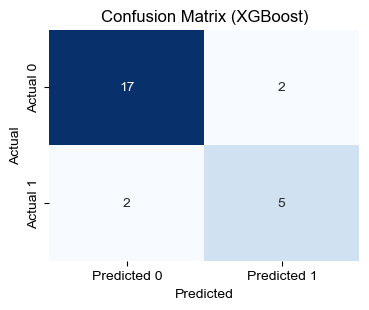

In [10]:



# Create a confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost)')
plt.show()


In [11]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_model = GradientBoostingClassifier()
gbc_model.fit(X_train, y_train)


GradientBoostingClassifier()

Accuracy: 0.65
              precision    recall  f1-score   support

         0.0       0.78      0.74      0.76        19
         1.0       0.38      0.43      0.40         7

    accuracy                           0.65        26
   macro avg       0.58      0.58      0.58        26
weighted avg       0.67      0.65      0.66        26



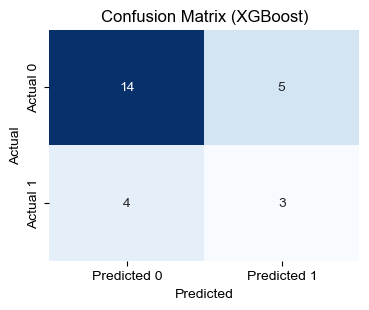

In [12]:
# Make predictions
y_pred_gbc = gbc_model.predict(X_test)

# Evaluate the performance
acc_gbc = accuracy_score(y_test, y_pred_gbc)
print(f'Accuracy: {acc_gbc:.2f}')
print(classification_report(y_test, y_pred_gbc))

# Create a confusion matrix
cm_gbc = confusion_matrix(y_test, y_pred_gbc)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_gbc, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost)')
plt.show()


In [19]:
#Accuracy Scores
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore")
# Example of cross-validation
cv_scores = cross_val_score(gbc_model, X_train, y_train, cv=3)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores)}')
# Example of evaluating on a test set
test_acc = gbc_model.score(X_test, y_test)
print(f'Test Accuracy: {test_acc}')
train_acc = gbc_model.score(X_train, y_train)
print(f'Train Accuracy: {train_acc}')



Cross-Validation Scores: [0.69230769 0.83333333 0.5       ]
Mean CV Score: 0.6752136752136751
Test Accuracy: 0.6538461538461539
Train Accuracy: 1.0


In [13]:
# from sklearn.neighbors import KNeighborsClassifier

# gbc_model = KNeighborsClassifier()
# gbc_model.fit(X_train, y_train)


In [14]:
# for col in X.columns:
#     if '[' in col or ']' in col or '<' in col:
#         print(col)